In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
import itertools
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')



In [31]:
data= sm.datasets.sunspots.load_pandas()
y = data.data
y

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0
...,...,...
304,2004.0,40.4
305,2005.0,29.8
306,2006.0,15.2
307,2007.0,7.5


In [32]:
#Приводимо стовпчик 'YEAR' до формату дата/час та встановлення його в якості індексу
y ['YEAR']=pd.to_datetime(y['YEAR'], format='%Y')
y.set_index('YEAR', inplace= True)
y
                          

,SUNACTIVITY
YEAR,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0
...,...
2004-01-01,40.4
2005-01-01,29.8
2006-01-01,15.2


In [33]:
# Первірка на відсутність даних
missing_number = y.isnull().sum()
missing_number_na = y.isna().sum()
missing_number, missing_number_na 



(SUNACTIVITY    0
 dtype: int64,
 SUNACTIVITY    0
 dtype: int64)

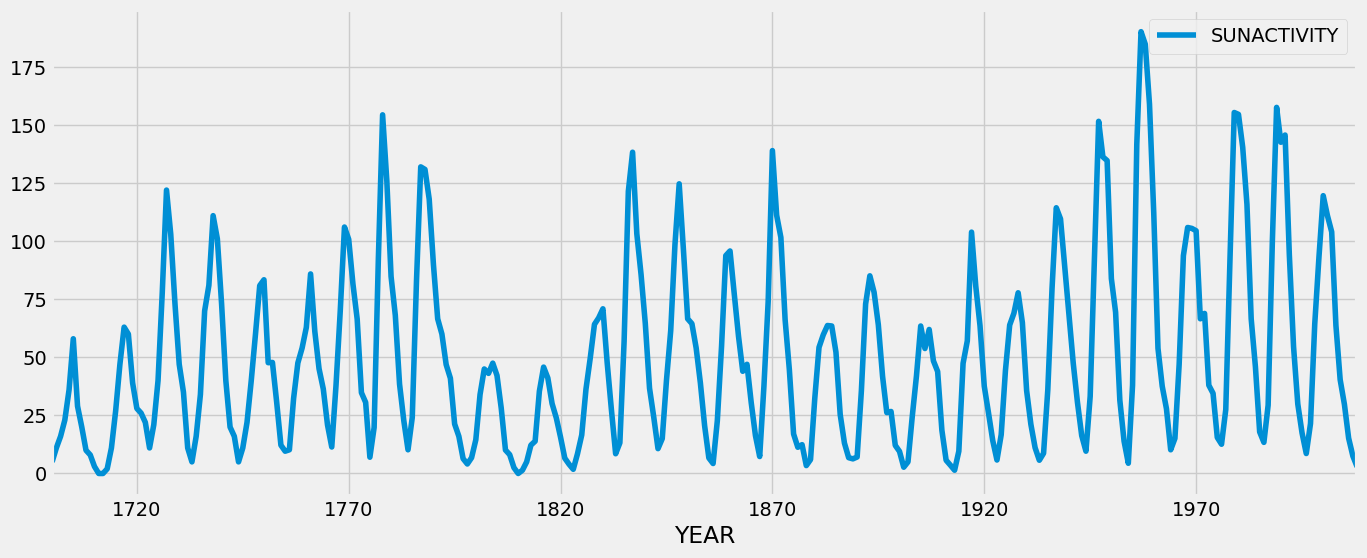

In [34]:
y.plot(figsize=(15, 6))
plt.show()

In [35]:
# Підбір параметрів p,d,q у діапазоні 0-3
p = d = q = range(0, 3)
# Генеруємо різні комбінації p, q и q
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [36]:
# Визначення найкращих параметрів AIC
best_aic = float('inf')
best_params = None
for p, d, q in pdq:
    try:
        model = sm.tsa.ARIMA(y, order=(p, d, q))
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_params = (p, d, q)
            
    except:
        continue

print(f'Кращі параметри: p={best_params[0]}, d={best_params[1]}, q={best_params[2]}')


Кращі параметри: p=2, d=1, q=2


In [37]:
#Cтворюємо і навчаємо модель Arima
mod = sm.tsa.ARIMA(y, order=(2,1,2))
results = mod.fit()


In [38]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6098      0.026     61.536      0.000       1.559       1.661
ar.L2         -0.9381      0.023    -41.582      0.000      -0.982      -0.894
ma.L1         -1.5185      0.055    -27.634      0.000      -1.626      -1.411
ma.L2          0.6440      0.059     10.857      0.000       0.528       0.760
sigma2       240.9492     16.173     14.898      0.000     209.250     272.648


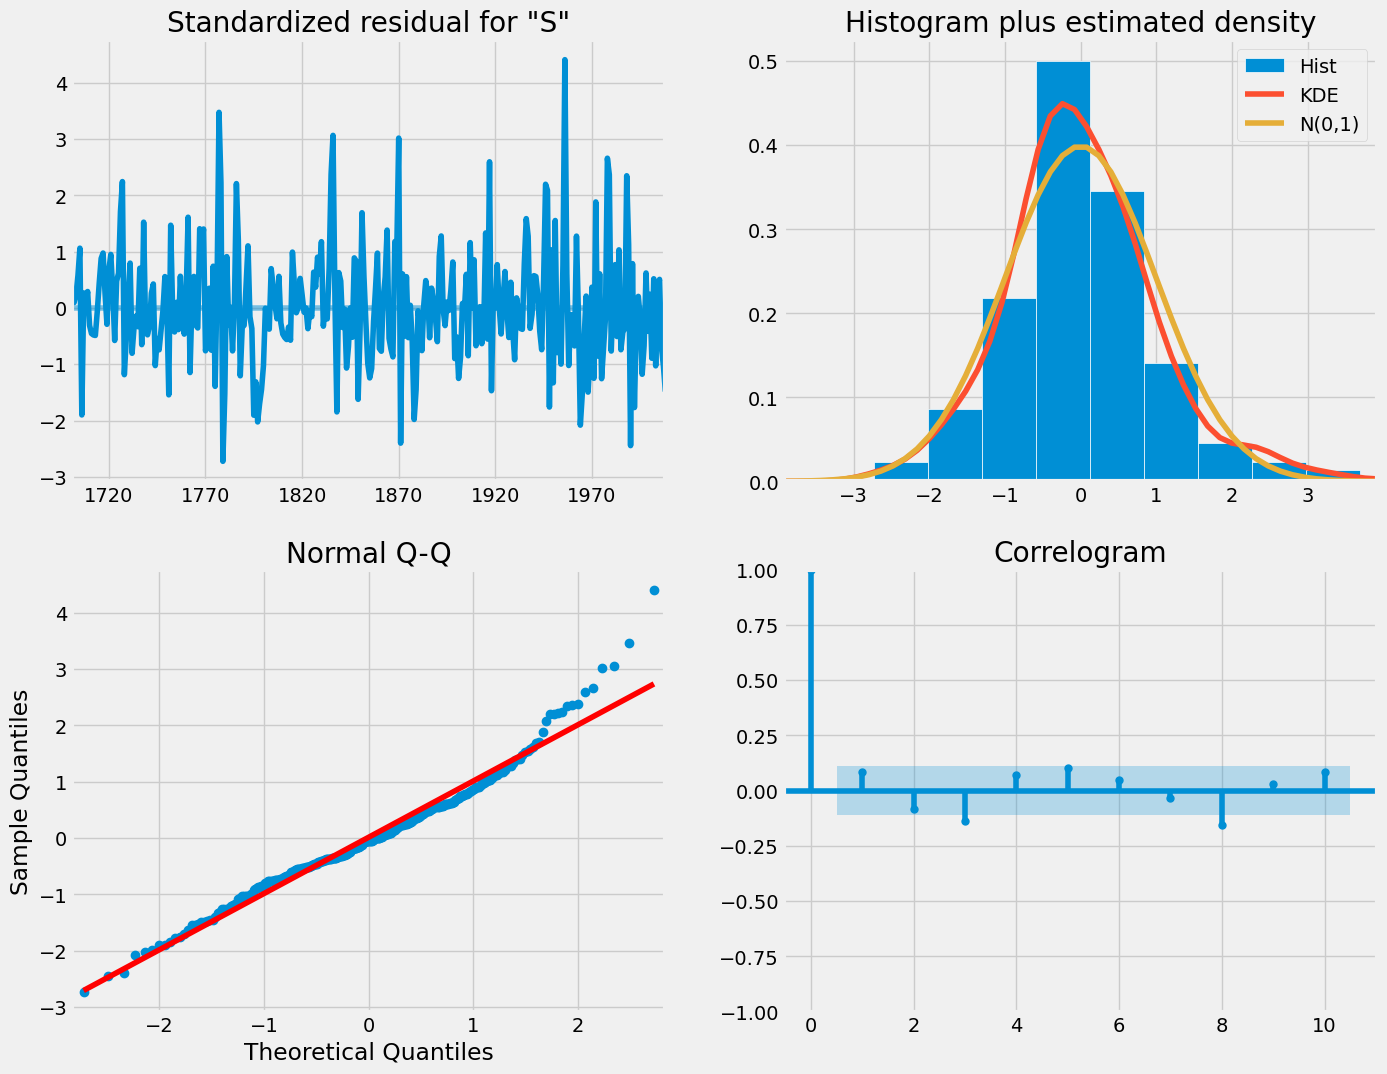

In [39]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [40]:
#Отримуємо прогноз щодо відомого періоду з 200 року на основі навченої моделі, а також розраховуємо довірчий інтервал для прогнозних значень
pred = results.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=False)
pred_ci = pred.conf_int()                 

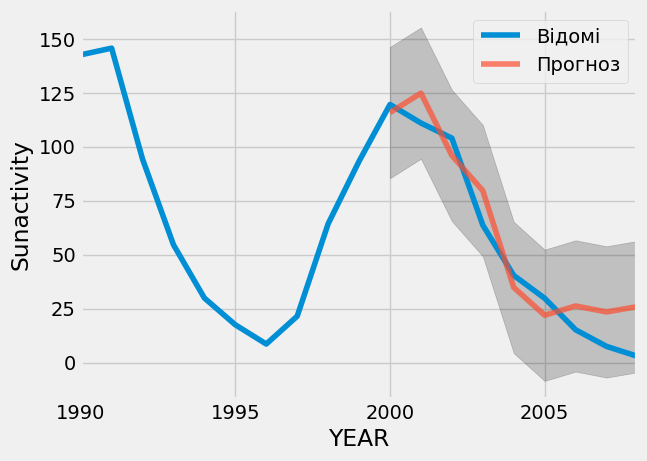

In [41]:
# Візуалізуємо прогноз
ax = y['1990-01-01':].plot()
pred.predicted_mean.plot(ax=ax, alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('YEAR')
ax.set_ylabel('Sunactivity')
plt.legend(labels=['Відомі', 'Прогноз']) 
plt.show()


In [42]:
#Середня квадратична похибка прогнозу
y_forecasted = pred.predicted_mean
y_truth = y['2000-01-01':]['SUNACTIVITY'] 
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Середня квадратична похибка прогнозу = {}'.format(round(mse, 2)))

Середня квадратична похибка прогнозу = 169.69


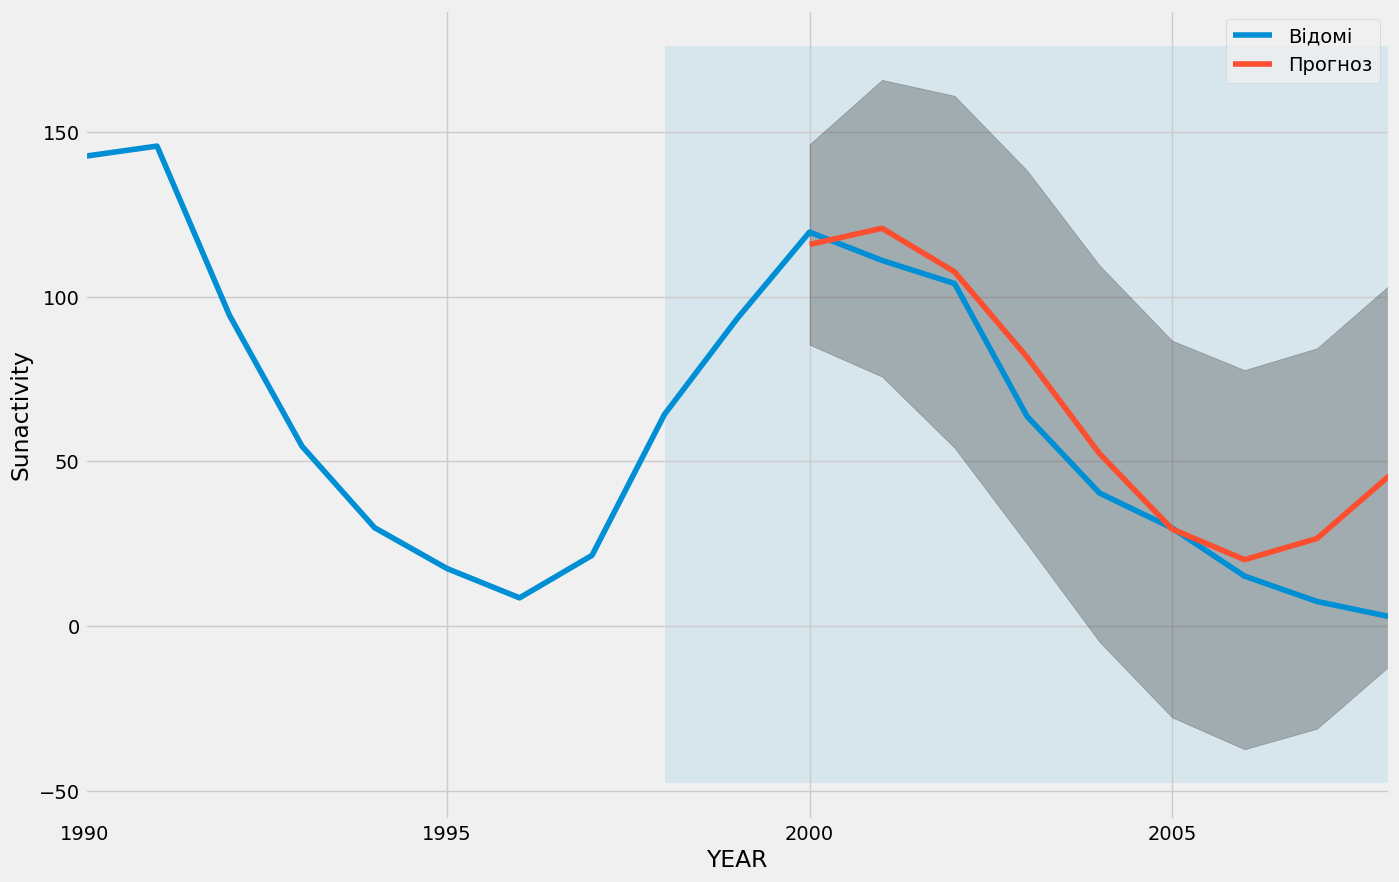

In [43]:
# Створення динамічного прогнозу
pred_dynamic = results.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y['1990':].plot(figsize=(15, 10))
pred_dynamic.predicted_mean.plot(ax=ax)
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)
ax.set_xlabel('YEAR')
ax.set_ylabel('Sunactivity')
plt.legend(labels=['Відомі', 'Прогноз']) 
plt.show()



In [44]:
# Отримуємо прогноз на 22 кроки у перед
pred_uc = results.get_forecast(steps=22)
# Отримуємо інтервал прогнозу
pred_ci = pred_uc.conf_int()


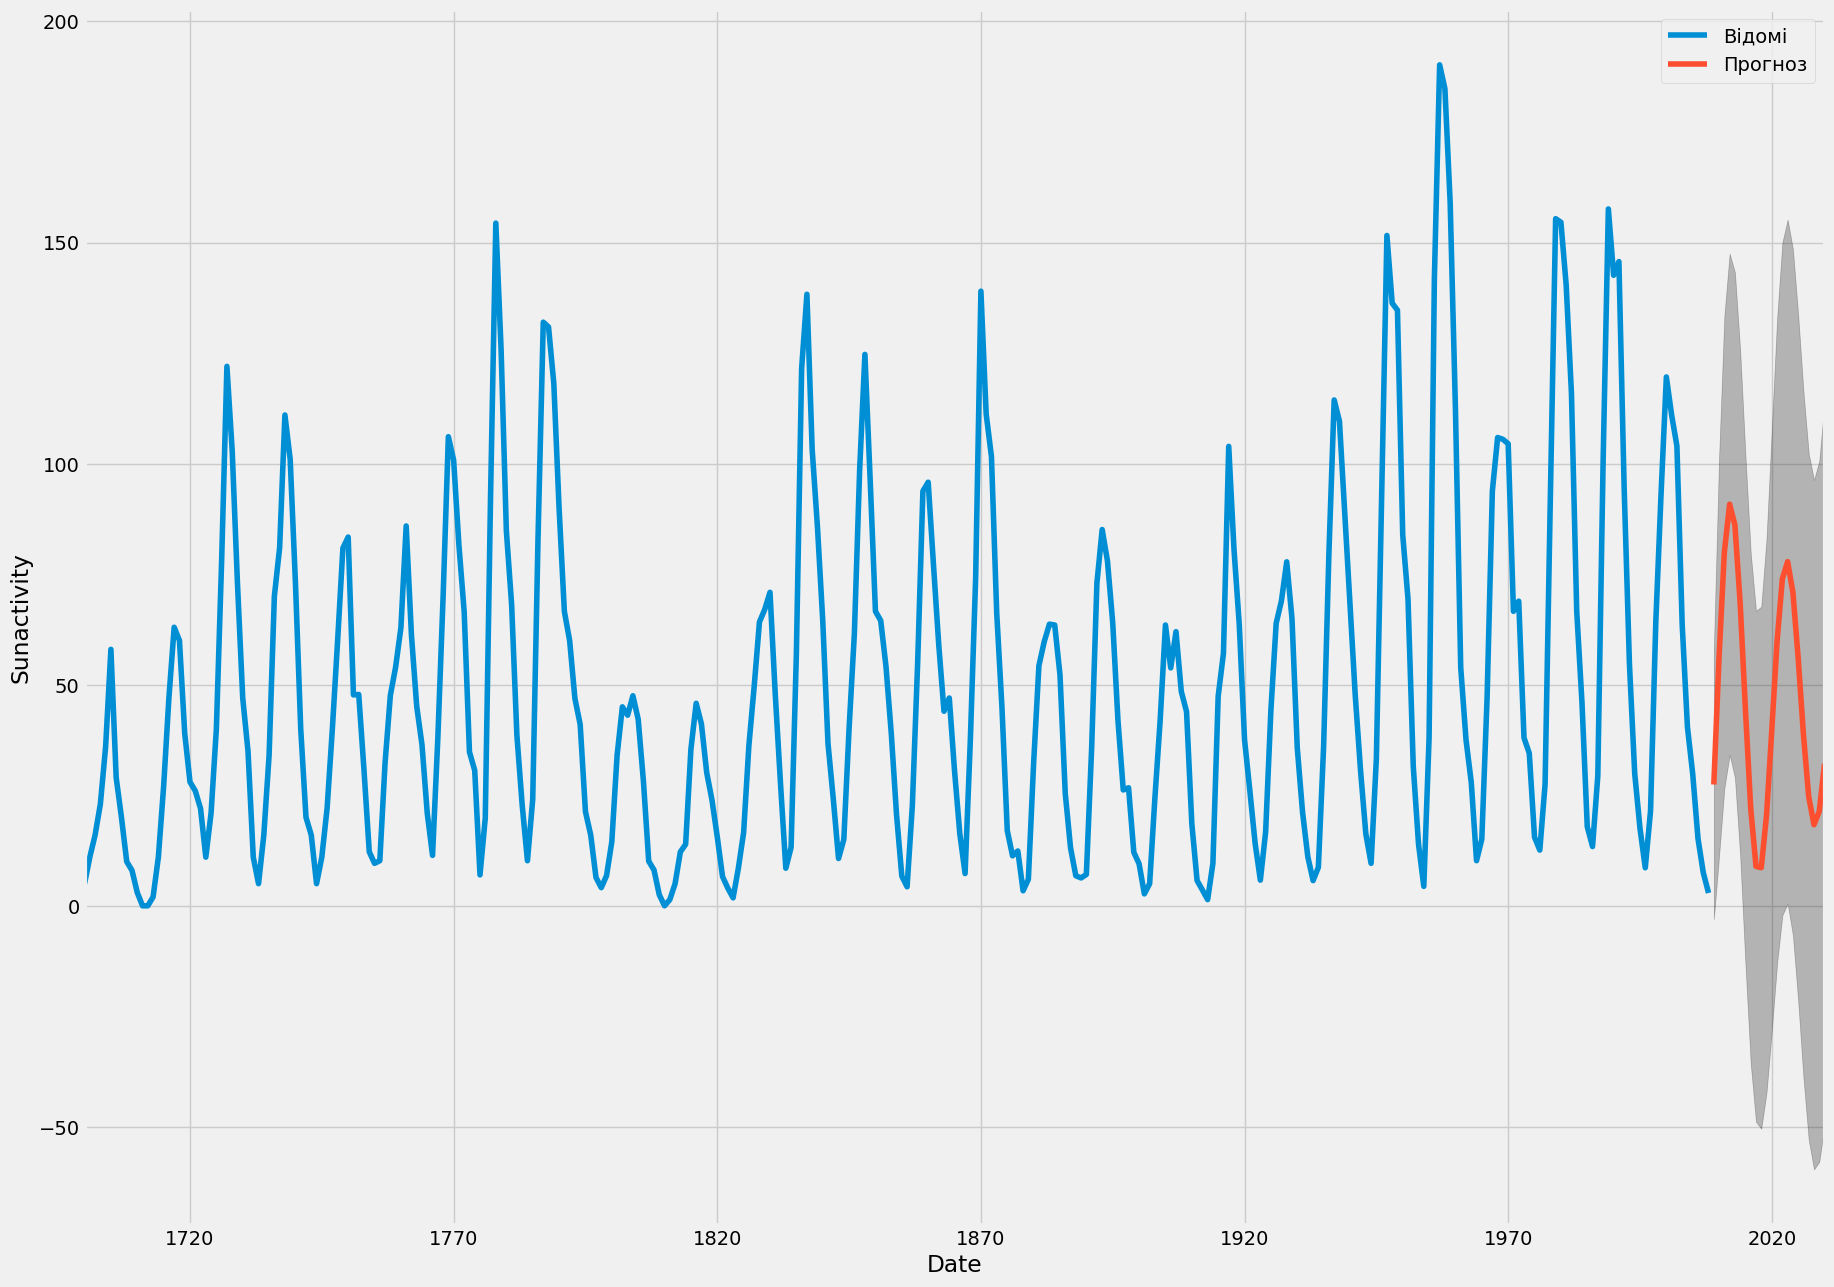

In [45]:
# Візуалізація прогнозу
ax = y.plot(label='Відомі', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Прогноз')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sunactivity')
plt.legend(labels=['Відомі', 'Прогноз']) 
plt.show()

In [46]:
# Результати прогнозу
for index, value in pred_uc.predicted_mean.iteritems():
    lower_bound = pred_ci.loc[index, 'lower SUNACTIVITY']
    upper_bound = pred_ci.loc[index, 'upper SUNACTIVITY']
    print(f"Date: {index}, Predicted Value: {value:.2f}, Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")

Date: 2009-01-01 00:00:00, Predicted Value: 27.43, Lower Bound: -3.00, Upper Bound: 57.85
Date: 2010-01-01 00:00:00, Predicted Value: 56.38, Lower Bound: 11.35, Upper Bound: 101.42
Date: 2011-01-01 00:00:00, Predicted Value: 79.99, Lower Bound: 26.58, Upper Bound: 133.40
Date: 2012-01-01 00:00:00, Predicted Value: 90.83, Lower Bound: 34.16, Upper Bound: 147.49
Date: 2013-01-01 00:00:00, Predicted Value: 86.13, Lower Bound: 28.99, Upper Bound: 143.27
Date: 2014-01-01 00:00:00, Predicted Value: 68.40, Lower Bound: 11.22, Upper Bound: 125.58
Date: 2015-01-01 00:00:00, Predicted Value: 44.27, Lower Bound: -13.28, Upper Bound: 101.81
Date: 2016-01-01 00:00:00, Predicted Value: 22.05, Lower Bound: -35.68, Upper Bound: 79.78
Date: 2017-01-01 00:00:00, Predicted Value: 8.92, Lower Bound: -48.86, Upper Bound: 66.70
Date: 2018-01-01 00:00:00, Predicted Value: 8.63, Lower Bound: -50.41, Upper Bound: 67.67
Date: 2019-01-01 00:00:00, Predicted Value: 20.48, Lower Bound: -42.19, Upper Bound: 83.15
D